In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from numba import jit
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import phik
from phik.report import plot_correlation_matrix
from phik import report

#### Data Ingestion

DATA DESCRIPTION:<br>
Input features:<br>
Objective: factual information;<br>
Examination: results of medical examination;<br>
Subjective: information given by the patient.<br>

Features:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary | 1-Yes, 0-No<br>
Alcohol intake | Subjective Feature | alco | binary | 1-Yes, 0-No<br>
Physical activity | Subjective Feature | active | binary | 1-Yes, 0-No<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 1-Yes, 0-No” <br>


In [3]:
#Reading in the data and storing it into a pandas dataframe
df = pd.read_csv('cardio_train 3.csv',sep=';') 

#### Data Pre-Processing

In [4]:
#display first 20 rows
df.head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


#### Checking for duplicate ids in the dataset

In [5]:
df['id'].value_counts() 
#no duplicates found hence keep all rows

0        1
66623    1
66631    1
66630    1
66628    1
        ..
33338    1
33339    1
33340    1
33341    1
99999    1
Name: id, Length: 70000, dtype: int64

Converting age from number of days to year

In [6]:
df['age'] = (df['age'] / 365.25).astype(int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Observation

In [7]:
df.info()
#The data is in an appropriate format and contains all its values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int32  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int32(1), int64(11)
memory usage: 6.7 MB


#### Data imputation to preserve statistical power, avoid bias as much as possible.

In [8]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
                                     'percent_missing': percent_missing})
    return missing_value_df

produce_missing_report(df) #Confirmed no data missing from the rows

,percent_missing
id,0.0
age,0.0
gender,0.0
height,0.0
weight,0.0
ap_hi,0.0
ap_lo,0.0
cholesterol,0.0
gluc,0.0
smoke,0.0


#### Data Standardization to ensure that all features have a similar scale and variance.

In [9]:
def standardize_col(col):
    scaler = StandardScaler()
    std_col = scaler.fit_transform(col.values.reshape(-1, 1))
    return std_col

standardize_col(df['age'])
standardize_col(df['height'])
standardize_col(df['weight'])
standardize_col(df['ap_hi'])
standardize_col(df['ap_lo'])
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Outlier Detection analysis on the age, height, weight, ap_hi, and ap_lo columns, since they are continuous numerical variables that may have outliers.

Performing outlier detection on the age column

In [10]:
df['age'].describe()

count    70000.000000
mean        52.803257
std          6.762462
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [11]:
Q1 = df['age'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['age'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  48.0
Q3  58.0
IQR 10.0


In [12]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  73.0
lower  33.0


In [13]:
df_without_outliers = df[(df['age'] < upper_bound) & (df['age'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x15e087e1bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x15e087e2110>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e087e1a50>],
 'medians': [<matplotlib.lines.Line2D at 0x15e087e2650>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e087e28f0>],
 'means': []}

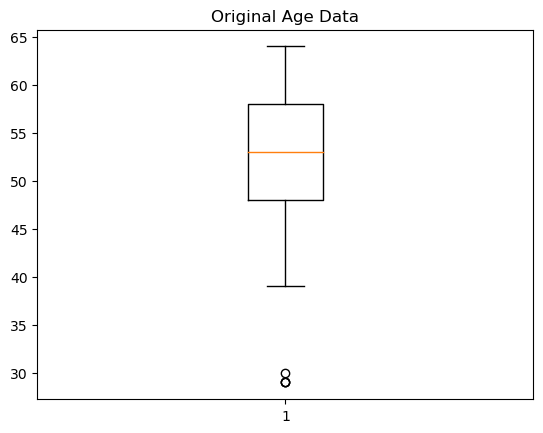

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Age Data')
ax1.boxplot(df['age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x15e09ca9750>,
 'caps': [<matplotlib.lines.Line2D at 0x15e09ca9c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e09ca95d0>],
 'medians': [<matplotlib.lines.Line2D at 0x15e09caa1d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e09caa470>],
 'means': []}

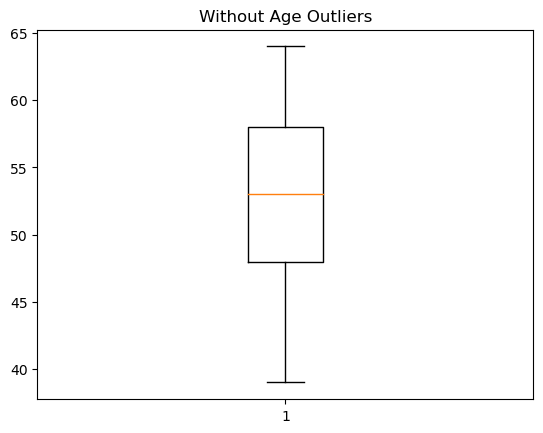

In [15]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['age'])

In [16]:
df_without_outliers = df[(df['age'] > lower_bound) & (df['age'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the height column

In [17]:
df['height'].describe() # uncertain of if this is needed, people have varied height doesnt mean it contributes to CVD. however the column continuous. do correlation matrix to see the relevance

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

In [18]:
Q1 = df['height'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['height'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  159.0
Q3  170.0
IQR 11.0


In [19]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  186.5
lower  142.5


In [20]:
df_without_outliers = df[(df['height'] < upper_bound) & (df['height'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x15e09d382e0>,
 'caps': [<matplotlib.lines.Line2D at 0x15e09d06f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e09d38040>],
 'medians': [<matplotlib.lines.Line2D at 0x15e09d38c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e09d38ee0>],
 'means': []}

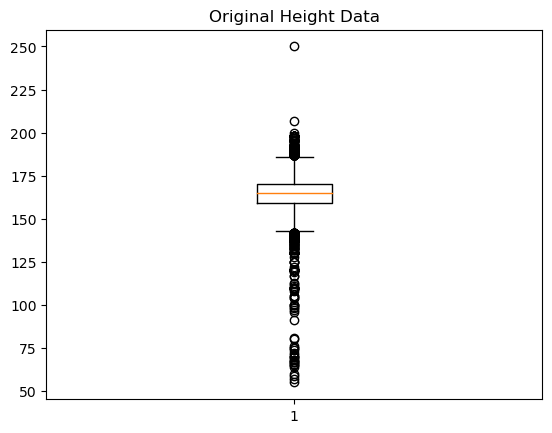

In [21]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Height Data')
ax1.boxplot(df['height'])

{'whiskers': [<matplotlib.lines.Line2D at 0x15e09db09d0>,
 'caps': [<matplotlib.lines.Line2D at 0x15e09db0f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e09db0730>],
 'medians': [<matplotlib.lines.Line2D at 0x15e09db1450>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e09db16f0>],
 'means': []}

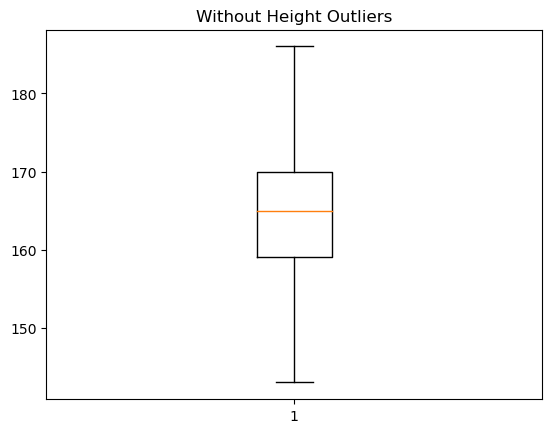

In [22]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Height Outliers')
ax1.boxplot(df_without_outliers['height'])

In [23]:
df_without_outliers = df[(df['height'] > lower_bound) & (df['height'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69473,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the weight column

In [24]:
df['weight'].describe()

count    69477.000000
mean        74.152953
std         14.287850
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

In [25]:
Q1 = df['weight'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['weight'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  65.0
Q3  82.0
IQR 17.0


In [26]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  107.5
lower  39.5


In [27]:
df_without_outliers = df[(df['weight'] < upper_bound) & (df['weight'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69471,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x15e09422a40>,
 'caps': [<matplotlib.lines.Line2D at 0x15e09422e60>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e094227a0>],
 'medians': [<matplotlib.lines.Line2D at 0x15e094233a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e09423640>],
 'means': []}

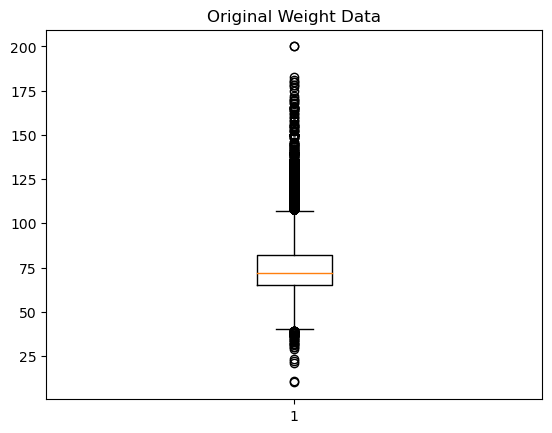

In [28]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Weight Data')
ax1.boxplot(df['weight'])

{'whiskers': [<matplotlib.lines.Line2D at 0x15e09496b60>,
 'caps': [<matplotlib.lines.Line2D at 0x15e094970a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e094968c0>],
 'medians': [<matplotlib.lines.Line2D at 0x15e094975e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e09497880>],
 'means': []}

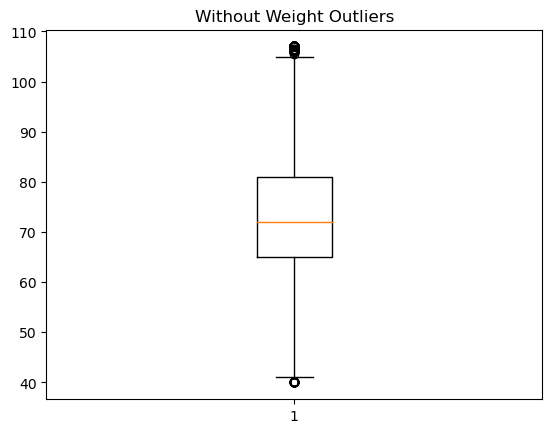

In [29]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Weight Outliers')
ax1.boxplot(df_without_outliers['weight'])

In [30]:
df_without_outliers = df[(df['weight'] > lower_bound) & (df['weight'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67716,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_hi column

In [31]:
df['ap_hi'].describe()

count    67719.000000
mean       128.585951
std        156.528328
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [32]:
Q1 = df['ap_hi'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_hi'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  120.0
Q3  140.0
IQR 20.0


In [33]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  170.0
lower  90.0


In [34]:
df_without_outliers = df[(df['ap_hi'] < upper_bound) & (df['ap_hi'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67713,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x15e0950f430>,
 'caps': [<matplotlib.lines.Line2D at 0x15e0950f850>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e0950f190>],
 'medians': [<matplotlib.lines.Line2D at 0x15e0950fd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e0b5c4070>],
 'means': []}

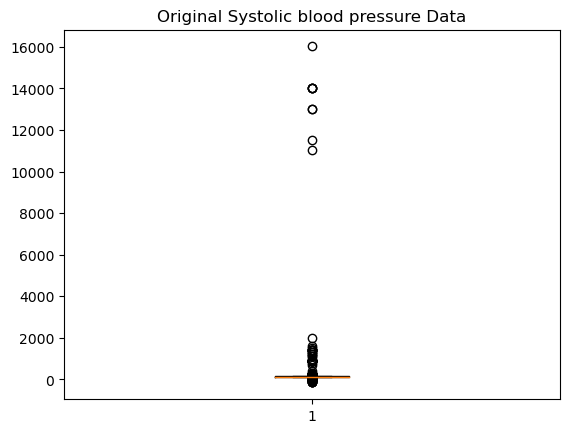

In [35]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Systolic blood pressure Data')
ax1.boxplot(df['ap_hi'])

{'whiskers': [<matplotlib.lines.Line2D at 0x15e0b5ffc70>,
 'caps': [<matplotlib.lines.Line2D at 0x15e0b6381f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e0b5ff9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x15e0b638730>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e0b6389d0>],
 'means': []}

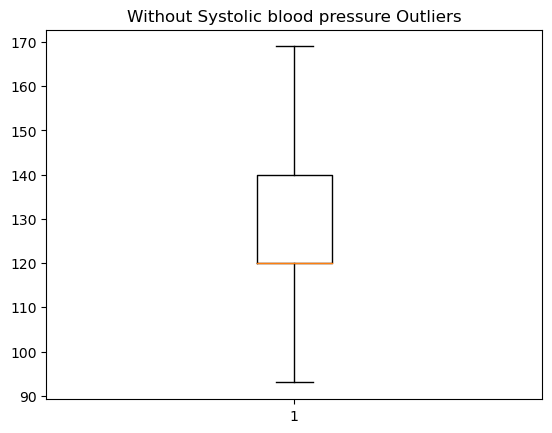

In [36]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Systolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_hi'])

In [37]:
df_without_outliers = df[(df['ap_hi'] > lower_bound) & (df['ap_hi'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_lo column

In [38]:
df['ap_lo'].describe()

count    64803.000000
mean        93.685107
std        181.503375
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      10000.000000
Name: ap_lo, dtype: float64

In [39]:
Q1 = df['ap_lo'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_lo'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  80.0
Q3  90.0
IQR 10.0


In [40]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  105.0
lower  65.0


In [41]:
df_without_outliers = df[(df['ap_lo'] < upper_bound) & (df['ap_lo'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
5,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x15e0b6a9030>,
 'caps': [<matplotlib.lines.Line2D at 0x15e0b6a9570>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e0b6a8d90>],
 'medians': [<matplotlib.lines.Line2D at 0x15e0b6a9ab0>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e0b6a9d50>],
 'means': []}

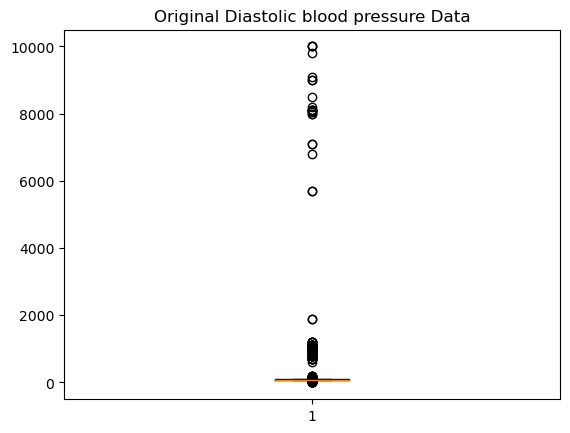

In [42]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Diastolic blood pressure Data')
ax1.boxplot(df['ap_lo'])

{'whiskers': [<matplotlib.lines.Line2D at 0x15e0b6f6860>,
 'caps': [<matplotlib.lines.Line2D at 0x15e0b72c250>,
 'boxes': [<matplotlib.lines.Line2D at 0x15e0b6f7b50>],
 'medians': [<matplotlib.lines.Line2D at 0x15e0b72c790>],
 'fliers': [<matplotlib.lines.Line2D at 0x15e0b72ca30>],
 'means': []}

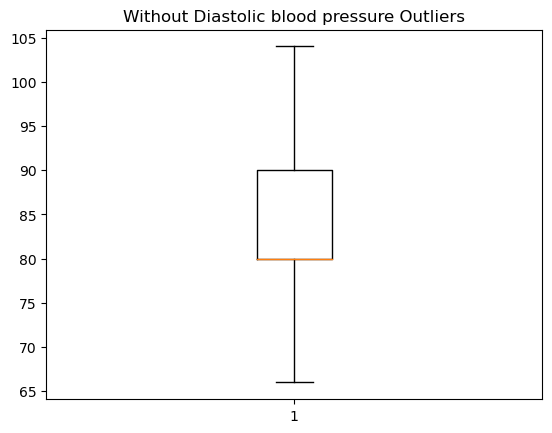

In [43]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Diastolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_lo'])

In [44]:
df_without_outliers = df[(df['ap_lo'] > lower_bound) & (df['ap_lo'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
61767,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
61768,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
61769,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


## EDA

In [46]:
#take a look at data types 
df_without_outliers.dtypes

id               int64
age              int32
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [ ]:
#declare colour patern for plots
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]